# Necessary imports and data loading

In [1]:
# necessary imports

import my_code
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.io import read_raw_edf
from mne.preprocessing import ICA

In [2]:
# loading the raw data (30 files in a list) 

path = os.getcwd()
raw_datasets = my_code.load_all_datasets(path = path)

Extracting EDF parameters from C:\Users\domin\Desktop\Thesis drafting\Giuseppe01_01.02.21_08.43.22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45055  =      0.000 ...   175.996 secs...
Extracting EDF parameters from C:\Users\domin\Desktop\Thesis drafting\Giuseppe02_02.02.21_08.30.42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45823  =      0.000 ...   178.996 secs...
Extracting EDF parameters from C:\Users\domin\Desktop\Thesis drafting\Giuseppe03_03.02.21_08.33.04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 45311  =      0.000 ...   176.996 secs...
Extracting EDF parameters from C:\Users\domin\Desktop\Thesis drafting\Giuseppe04_03.02.21_08.43.13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 47103  =      0.000 ...   183.996 secs...
Extracting EDF param

# Pre-processing

In [3]:
# pre-processing the raw data:
# setting the reference electrodes to 'CQ_CMS', 'CQ_DRL'
# setting the montage
# high pass filter at 0.16 Hz to remove slow drifts (potentially built in in the EEG headset)
# no notch-filtering as it is built in in the EEG headset 
# annotating the raw data so that we have 5 instances of push VI, 5 instances of relax VI per dataset
# creating events from annotations 

pre_processed_datasets = my_code.preliminary_steps(raw_datasets)

EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Filter length: 5281 samples (20.629 sec)

Used Annotations descriptions: ['Push', 'Relax']
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
-

Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Filter length: 5281 samples (20.629 sec)

Used Annotations descriptions: ['Push', 'Relax']
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB c

Setting up high-pass filter at 0.16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Filter length: 5281 samples (20.629 sec)

Used Annotations descriptions: ['Push', 'Relax']
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Filter length: 5281 samples (20.629 sec)

Used A

# Epoch creation

In [4]:
# creating epochs from the events (starting at 0.5 s of a push/relax instance and ending at 9.5 s of a push/relax instance)

# first, creating a set of epochs based just on one dataset

events_from_annot, event_dict = mne.events_from_annotations(pre_processed_datasets[0])
event_dict = {"Push" : 1, "Relax" : 2}
baseline = (0.5, 0.5)
delay = 0.5
epochs_all = mne.Epochs(pre_processed_datasets[0], events=events_from_annot, event_id = event_dict, baseline = baseline, tmin = 0.5, tmax = (10-delay), preload = True, reject_by_annotation=False)

# then, looping it so more sets of epochs are appended 

epochs_all = my_code.create_epochs(pre_processed_datasets=pre_processed_datasets)

Used Annotations descriptions: ['Push', 'Relax']
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2305 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Push', 'Relax']
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2305 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2305 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 p

0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2305 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
240 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2305 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
250 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2305 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
260 matching ev

# Applying different cleaning & artifact detection methods

#### ICA --> peak to peak 

Fitting ICA to data using 14 channels (please be patient, this may take a while)


<ipython-input-5-4f90ad862aed>:9: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=14, random_state=97)
<ipython-input-5-4f90ad862aed>:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_ica)


Selecting by number: 14 components
Fitting ICA took 8.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components


<ipython-input-5-4f90ad862aed>:12: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_ica = ica.apply(epochs_ica)


    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'O1', 'P8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'P7', 'O1', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['P8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['AF3', 'F7', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    Rejecting  epoch based on EEG : ['F

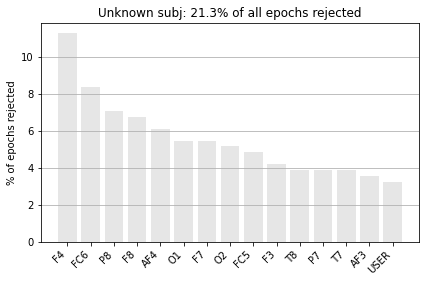

Dropped 14 epochs: 0, 5, 6, 7, 10, 11, 16, 17, 122, 145, 148, 165, 206, 235


(<Epochs |  230 events (all good), 0.5 - 9.5 sec, baseline 0.5 – 0.5 sec, ~56.7 MB, data loaded,
  'Push': 115
  'Relax': 115>,
 array([  0,   5,   6,   7,  10,  11,  16,  17, 122, 145, 148, 165, 206,
        235], dtype=int64))

In [5]:
# artifact detection/repair/deletion mix 1
# first ICA; visualize the components

#my_code.apply_ica(epochs_all)

    # decide which components to reject and reject them
    
epochs_ica = epochs_all.copy()
ica = ICA(n_components=14, random_state=97)
ica.fit(epochs_ica)
ica.exclude = [1,3]
epochs_ica = ica.apply(epochs_ica)

# then peak-to-peak amplitude rejection threshold of 200 mV

reject_criteria = dict(eeg=200e-6)

epochs_ica_ptp_200 = epochs_ica.drop_bad(reject=reject_criteria)
print(epochs_ica_ptp_200.drop_log)
epochs_ica_ptp_200.plot_drop_log()

# equalizing instance counts

epochs_ica_ptp_200.equalize_event_counts(epochs_ica_ptp_200.event_id)

#### peak to peak --> ICA 

In [ ]:
# artifact detection/repair/deletion mix 2

# first peak-to-peak amplitude rejection threshold of 150 mV
epochs_ptp_200 = epochs_all.copy()
reject_criteria = dict(eeg=200e-6)

epochs_ptp_200 = epochs_ptp_200.drop_bad(reject=reject_criteria)
print(epochs_ptp_200.drop_log)
epochs_ptp_200.plot_drop_log()

# then ICA; visualize the components

my_code.apply_ica(epochs_ptp_200)

    # decide which components to reject and reject them
    
ica = ICA(n_components=14, random_state=97)
ica.fit(epochs_ptp_200)
ica.exclude = [1,3]
epochs_ptp_200_ica = ica.apply(epochs_ptp_200)

# equalizing instance counts

epochs_ptp_200_ica.equalize_event_counts(epochs_ptp_200_ica.event_id)


#### ICA --> Autoreject

In [ ]:
# artifact detection/repair/deletion mix 3


# first ICA; visualize the components

#my_code.apply_ica(epochs_all)

    # decide which components to reject and reject them
    
epochs_ica = epochs_all.copy()
ica = ICA(n_components=14, random_state=97)
ica.fit(epochs_ica)
ica.exclude = [1,3]
epochs_ica = ica.apply(epochs_ica)

# then Autoreject

epochs_ica_autoreject = my_code.clean_epochs(epochs_all = epochs_ica)

# equalizing instance counts

epochs_ica_autoreject.equalize_event_counts(epochs_ica_autoreject.event_id)

#### Autoreject --> ICA 

In [ ]:
# artifact detection/repair/deletion mix 4

# first Autoreject

epochs_autoreject = epochs_all.copy()
epochs_autoreject = my_code.clean_epochs(epochs_all = epochs_autoreject)


# then ICA; visualize the components

#my_code.apply_ica(epochs_autoreject)

    # decide which components to reject and reject them
    
ica = ICA(n_components=14, random_state=97)
ica.fit(epochs_autoreject)
ica.exclude = [1,3]
epochs_autoreject_ica = ica.apply(epochs_autoreject)

# equalizing instance counts

epochs_autoreject_ica.equalize_event_counts(epochs_autoreject_ica.event_id)


# Feature extraction methods

## Time-frequency

In [6]:
alpha_push_power, alpha_relax_power = my_code.create_TF_object_for_plotting(8, 12, 20, epochs_ica_ptp_200["Push"], epochs_ica_ptp_200["Relax"])
beta_push_power, beta_relax_power = my_code.create_TF_object_for_plotting(12, 30, 20, epochs_ica_ptp_200["Push"], epochs_ica_ptp_200["Relax"])
gamma_push_power, gamma_relax_power = my_code.create_TF_object_for_plotting(30, 80, 20, epochs_ica_ptp_200["Push"], epochs_ica_ptp_200["Relax"])

## PyEEG features

In [7]:
# extracting detrended fluctuation analysis coefficients, fisher information, hurst component
# hjorth fractal dimension, hjirth mobility, hjorth complexity, petrosian fractal dimension

In [8]:
fi_epochs_over_channels_push, dfa_epochs_over_channels_push, he_epochs_over_channels_push, hfd_epochs_over_channels_push, hm_epochs_over_channels_push, hc_epochs_over_channels_push, pfd_epochs_over_channels_push, fi_epochs_over_channels_push, dfa_epochs_over_channels_push, he_epochs_over_channels_push, hfd_epochs_over_channels_push, hm_epochs_over_channels_push, hc_epochs_over_channels_push, pfd_epochs_over_channels_push, fi_epochs_over_channels_relax, dfa_epochs_over_channels_relax, he_epochs_over_channels_relax, hfd_epochs_over_channels_relax, hm_epochs_over_channels_relax, hc_epochs_over_channels_relax, pfd_epochs_over_channels_relax,all_pyeeg_features = my_code.extract_pyeegfeatures(115, epochs_ica_ptp_200["Push"],epochs_ica_ptp_200["Relax"]) 

(115,)


D:\Anaconda\envs\tf\lib\site-packages\pyeeg-0.4.4-py3.8.egg\pyeeg\detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
D:\Anaconda\envs\tf\lib\site-packages\pyeeg-0.4.4-py3.8.egg\pyeeg\detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(115, 14)
(115, 14)
(115, 14)
(115, 14)


D:\Anaconda\envs\tf\lib\site-packages\pyeeg-0.4.4-py3.8.egg\pyeeg\hurst.py:54: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\envs\tf\lib\site-packages\pyeeg-0.4.4-py3.8.egg\pyeeg\hurst.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(115, 14)
(115, 14)


D:\Anaconda\envs\tf\lib\site-packages\pyeeg-0.4.4-py3.8.egg\pyeeg\fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(115, 14)
(115, 14)
(115, 14)
(115, 14)
(115, 14)
(115, 14)
(115, 14)
(115, 14)


## Common Spatial Patterns

In [9]:
# introductory explanation

## Principle Component Analysis

In [10]:
# introductory explanation

## RGB values from spectrogram images

In [11]:
# introductory explanation

# Data exploration informing feature-engineering

### Plotting averaged epochs per class

In [12]:
print(epochs_ica_ptp_200)
#print(epochs_ptp_200_ica)
#print(epochs_ica_autoreject)
#print(epochs_autoreject_ica)

<Epochs |  230 events (all good), 0.5 - 9.5 sec, baseline 0.5 – 0.5 sec, ~56.7 MB, data loaded,
 'Push': 115
 'Relax': 115>


combining channels using "gfp"
combining channels using "gfp"


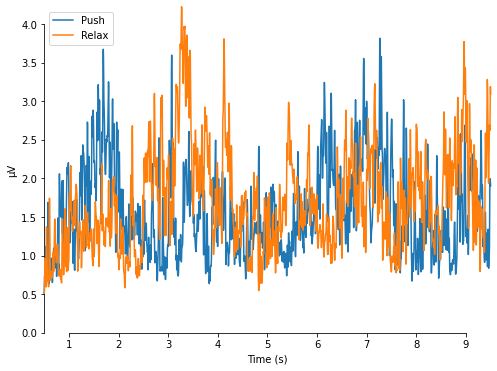

[<Figure size 576x432 with 1 Axes>]

In [13]:
# visually inspecting the epochs: plotting their averages 
# need to update it for all the artifact rejection mixes

push_average = epochs_ica_ptp_200["Push"].average()
relax_average = epochs_ica_ptp_200["Relax"].average()
mne.viz.plot_compare_evokeds([push_average, relax_average])

### Plotting topomaps of time-frequency data

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


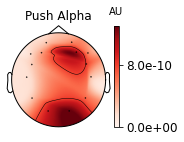

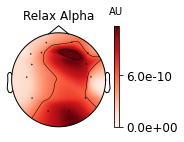

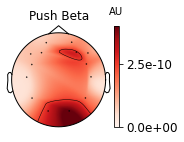

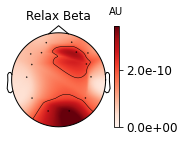

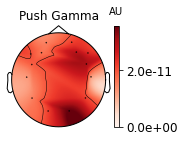

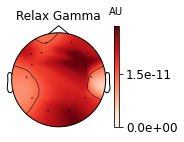

In [14]:
my_code.plot_topomaps(alpha_push_power, alpha_relax_power,  beta_push_power, beta_relax_power,  gamma_push_power,  gamma_relax_power)

### Plotting alpha, beta, gamma power differences per channel

Alpha differences values in 1st chunk:
 [9.083517760205455e-11, 9.46541459188724e-11, 4.8658540006303647e-11, 1.4444180065200064e-10, 7.997909715046301e-11, 4.44982358827584e-11, 8.293050659191017e-11, 2.129842939650927e-10, 8.045544667522856e-12, 6.340603111430128e-11, 4.1992980395830095e-11, 1.1025650219870092e-10, 3.1431874595430747e-10, 3.5024675113520665e-10]
Alpha differences values in 2nd chunk:
 [7.278619652080457e-11, 9.86830095127106e-11, 6.084818087930195e-11, 1.229168882839312e-10, 6.984530333181142e-11, 1.1458566899874808e-10, 9.13186976619996e-11, 1.598432872860786e-10, 3.0552277473809976e-11, 5.1232265619313727e-11, 6.539712061699699e-11, 6.410112313678796e-12, 9.929731414330843e-12, 1.0409086899273254e-10]
Alpha differences values in 3rd chunk:
 [1.0866951439711041e-10, 2.0568918362300937e-10, 3.462275239898584e-11, 1.589386824087208e-10, 1.689508396111152e-10, 3.216979630747906e-10, 5.32153985778865e-11, 3.1431378687403385e-10, 1.4004666111211563e-11, 8.072010338719493

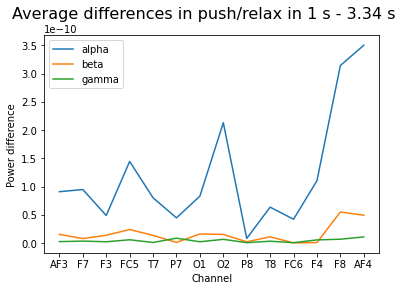

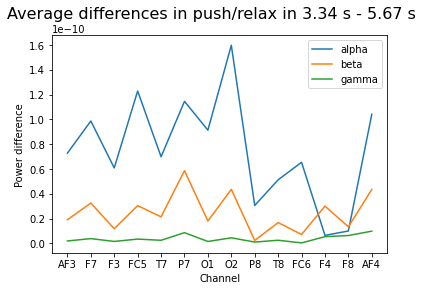

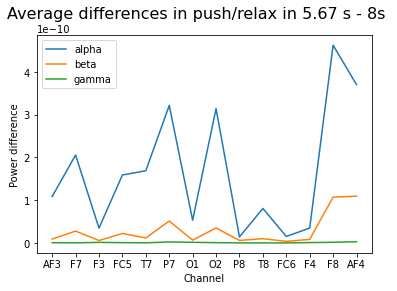

In [15]:
my_code.visualize_per_channel_power_diffs(epochs_all,alpha_push_power, alpha_relax_power,  beta_push_power, beta_relax_power,  gamma_push_power,  gamma_relax_power)

### Running SlidingEstimator on time-frequency data

In [16]:
# extracting alpha, beta, gamma frequencies and their mixes per channel over time 
# needs a new function as we want matrices, not time-frequency objects
# repeat for every artifact rejection mix 

freqs, alpha_push_power, alpha_push_itc, instances = my_code.create_time_frequency_matrices(8, 12, 20, 115, 14, 769, epochs_ica_ptp_200["Push"])
freqs, alpha_relax_power, alpha_relax_itc, instances = my_code.create_time_frequency_matrices(8, 12, 20, 115, 14, 769, epochs_ica_ptp_200["Relax"])
freqs, beta_push_power, beta_push_itc, instances = my_code.create_time_frequency_matrices(13, 30, 20, 115, 14, 769, epochs_ica_ptp_200["Push"])
freqs, beta_relax_power, beta_relax_itc, instances = my_code.create_time_frequency_matrices(13, 30, 20, 115, 14, 769, epochs_ica_ptp_200["Relax"])
freqs, gamma_push_power, gamma_push_itc, instances = my_code.create_time_frequency_matrices(30, 80, 20, 115, 14, 769, epochs_ica_ptp_200["Push"])
freqs, gamma_relax_power, gamma_relax_itc, instances = my_code.create_time_frequency_matrices(30, 80, 20, 115, 14, 769, epochs_ica_ptp_200["Relax"])
alpha_beta_push_power = np.concatenate((alpha_push_power, beta_push_power), axis=3)
alpha_beta_relax_power = np.concatenate((alpha_relax_power, beta_relax_power), axis=3)
alpha_beta_gamma_push_power = np.concatenate((alpha_beta_push_power, gamma_push_power), axis=3)
alpha_beta_gamma_relax_power = np.concatenate((alpha_beta_relax_power, gamma_relax_power), axis=3)


Mean cross-validation score across all timepoints: 0.543


C:\Users\domin\Desktop\Thesis drafting\my_code.py:689: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Mean cross-validation score across all timepoints: 0.535


C:\Users\domin\Desktop\Thesis drafting\my_code.py:689: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Mean cross-validation score across all timepoints: 0.519


C:\Users\domin\Desktop\Thesis drafting\my_code.py:689: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


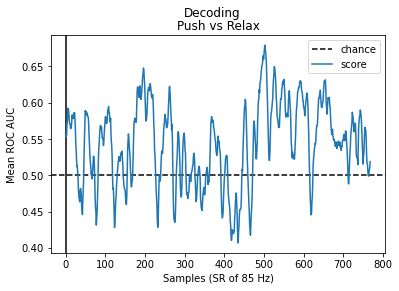

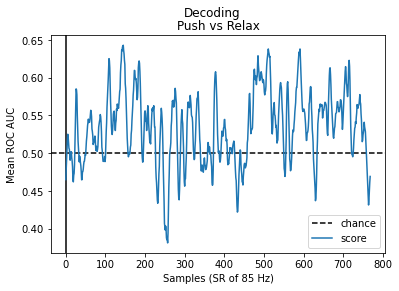

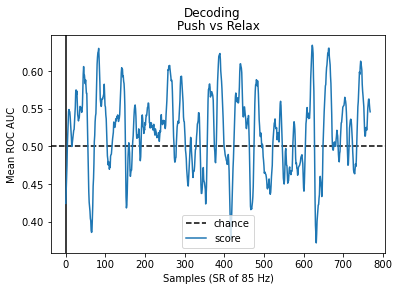

In [17]:
# running a series of SlidingEstimators to see where the different frequencies achieve biggest accuracy

alpha_push_power_channels, alpha_relax_power_channels, mean_scores_alpha = my_code.sliding_estimator(alpha_push_power, alpha_relax_power, 115, 769)
beta_push_power_channels, beta_relax_power_channels, mean_scores_beta = my_code.sliding_estimator(beta_push_power, beta_relax_power, 115, 769)
gamma_push_power_channels, gamma_relax_power_channels, mean_scores_gamma = my_code.sliding_estimator(gamma_push_power, gamma_relax_power, 115, 769)

# repeat for every artifact rejection mix 

In [18]:
# cropping data into different times & channels based on SlidingEstimator and visual inspection of my method

# based on LDA on frequency data from all epoch (choosing timepoints that gave SE an accuracy over a certain threshold)

res_alpha = []
for idx in range(0, len(mean_scores_alpha)) :
    if mean_scores_alpha[idx] > 0.60:
        res_alpha.append(idx)

samples_alpha_push = alpha_push_power_channels[:,:,res_alpha]
samples_alpha_relax = alpha_push_power_channels[:,:,res_alpha]

# based on my own visual inspection

    #visualinspection_alpha_push = alpha_push_power_channels[:,:,my_timepoints]
    #visualinspection_alpha_relax = alpha_push_power_channels[:,:,my_timepoints]

# cropping channels based on my own visual inspection 

    # e.g. choosing only O2, F8, F7, AF4, P7 for alpha frequencies; channel indices: O2 - 7, F8 - 12, F7 - 1, AF3 - 13, P7 - 5
    

alpha_push_power_croppedchannels = my_code.select_channels((7,12,1,13,5), alpha_push_power, 115, 769)
alpha_relax_power_croppedchannels = my_code.select_channels((7,12,1,13,5), alpha_relax_power, 115, 769)

In [19]:
# classifying different combinations of the TF data by LDA, SVM and DL architectures

# alpha frequencies from different artifact mixes 

    # e.g. 

alpha_mix1_data, alpha_scores_lda_mix1 = my_code.run_lda(alpha_push_power, alpha_relax_power, 115)
alpha_mix1_data, alpha_scores_svm_mix1 = my_code.run_svm(alpha_push_power, alpha_relax_power, 115)

# beta frequencies from different artifact mixes 

    # e.g. 

beta_mix1_data, beta_scores_lda_mix1 = my_code.run_lda(beta_push_power, beta_relax_power, 115)
beta_mix1_data, beta_scores_svm_mix1 = my_code.run_svm(beta_push_power, beta_relax_power, 115)

# gamma frequencies from different artifact mixes 

    # e.g. 

gamma_mix1_data, gamma_scores_lda_mix1 = my_code.run_lda(gamma_push_power, gamma_relax_power, 115)
gamma_mix1_data, gamma_scores_svm_mix1 = my_code.run_svm(gamma_push_power, gamma_relax_power, 115)

# alpha&beta frequencies from different artifact mixes 

    # e.g. 

alpha_beta_mix1_data, alpha_beta_scores_lda_mix1 = my_code.run_lda(alpha_beta_push_power, alpha_beta_relax_power, 115)
alpha_beta_mix1_data, alpha_beta_scores_svm_mix1 = my_code.run_svm(alpha_beta_push_power, alpha_beta_relax_power, 115)

# alpha, beta&gamma frequencies from different artifact mixes 

    # e.g. 

alpha_beta_gamma_mix1_data, alpha_beta_gamma_scores_lda_mix1 = my_code.run_lda(alpha_beta_gamma_push_power, alpha_beta_gamma_relax_power, 115)
alpha_beta_gamma_mix1_data, alpha_beta_gamma_scores_svm_mix1 = my_code.run_svm(alpha_beta_gamma_push_power, alpha_beta_gamma_relax_power, 115)



LDA Classification accuracy: 0.5782608695652175


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.6308695652173911 (std. 0.15839996276564836)
LDA Classification accuracy: 0.6108695652173913


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.6143478260869565 (std. 0.1518387613615043)
LDA Classification accuracy: 0.532608695652174


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.5539130434782609 (std. 0.1685162649983618)
LDA Classification accuracy: 0.6347826086956522


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.6230434782608695 (std. 0.15753356530148538)
LDA Classification accuracy: 0.65


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.6234782608695651 (std. 0.1551046966365447)


In [20]:
# classification of alpha frequencies at timpoints where SE accuracy was higher than 65%

alpha_samples_mix1_data, alpha_samples_scores_lda_mix1 = my_code.run_lda(samples_alpha_push, samples_alpha_relax, 115)
alpha_samples_mix1_data, alpha_samples_scores_svm_mix1 = my_code.run_svm(samples_alpha_push, samples_alpha_relax, 115)

# classification of alpha frequencies from different channels based on visual inspection 

alpha_cropped_channels_mix1_data, alpha_cropped_channels_scores_lda_mix1  = my_code.run_lda(alpha_push_power_croppedchannels, alpha_relax_power_croppedchannels, 115)
alpha_cropped_channels_mix1_data, alpha_cropped_channels_scores_svm_mix1 = my_code.run_svm(alpha_push_power_croppedchannels, alpha_relax_power_croppedchannels, 115)


# repeat those combination for the rest of frequency bands and the rest of artifact rejection mixes 


LDA Classification accuracy: 0.29130434782608694


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.23478260869565218 (std. 0.10218778814207018)
LDA Classification accuracy: 0.582608695652174


D:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM Classification score: 0.5491304347826087 (std. 0.16171399991768237)


In [ ]:
# using pyEEG module to extract the features
# TO MODULARIZE THE CODE


import pyeeg

channels_list = np.arange(14)
channels_list
instances = np.arange(115)
print(instances.shape)

push_epochs_data = epochs_all["Push"]
relax_epochs_data = epochs_all["Relax"]

push_epochs_data = push_epochs_data.get_data()
relax_epochs_data = relax_epochs_data.get_data()




#### Extracting DFA parameters

dfa_per_channel_push = np.zeros(shape=(14))
dfa_epochs_over_channels_push = np.zeros(shape=(115, 14))
dfa_per_channel_relax = np.zeros(shape=(14))
dfa_epochs_over_channels_relax = np.zeros(shape=(115, 14))

for instance in instances:
    
    for channel in channels_list:
        dfa_push = pyeeg.dfa(push_epochs_data[instance, channel])
        dfa_per_channel_push[channel]=dfa_push
        dfa_relax = pyeeg.dfa(relax_epochs_data[instance, channel])
        dfa_per_channel_relax[channel]=dfa_relax
    
    dfa_epochs_over_channels_push[instance] = dfa_per_channel_push
    dfa_epochs_over_channels_relax[instance] = dfa_per_channel_relax

print(dfa_epochs_over_channels_push.shape)
print(dfa_epochs_over_channels_relax.shape)

#### Extracting Fisher Information

fi_per_channel_push = np.zeros(shape=(14))
fi_epochs_over_channels_push = np.zeros(shape=(115, 14))
fi_per_channel_relax = np.zeros(shape=(14))
fi_epochs_over_channels_relax = np.zeros(shape=(115, 14))

for instance in instances:
    
    for channel in channels_list:
        fi_push = pyeeg.fisher_info(push_epochs_data[instance, channel],1, 2)
        fi_per_channel_push[channel]=fi_push
        fi_relax = pyeeg.fisher_info(relax_epochs_data[instance, channel], 1,2)
        fi_per_channel_relax[channel]=fi_relax
    
    fi_epochs_over_channels_push[instance] =  fi_per_channel_push
    fi_epochs_over_channels_relax[instance] =  fi_per_channel_relax

print(fi_epochs_over_channels_push.shape)
print(fi_epochs_over_channels_relax.shape)

#### Extracting Hurst Exponent

pyeeg.hurst(push_epochs_data[6, 4])

he_per_channel_push = np.zeros(shape=(14))
he_epochs_over_channels_push = np.zeros(shape=(115, 14))
he_per_channel_relax = np.zeros(shape=(14))
he_epochs_over_channels_relax = np.zeros(shape=(115, 14))

for instance in instances:
    
    for channel in channels_list:
        he_push = pyeeg.hurst(push_epochs_data[instance, channel])
        he_per_channel_push[channel]=he_push
        he_relax = pyeeg.hurst(push_epochs_data[instance, channel])
        he_per_channel_relax[channel]=he_relax
    
    he_epochs_over_channels_push[instance] =  he_per_channel_push
    he_epochs_over_channels_relax[instance] =  he_per_channel_relax

print(he_epochs_over_channels_push.shape)
print(he_epochs_over_channels_relax.shape)

#### Extracting Hjorth Fractal Dimension 

### according to a paper saved in my feature extraction folder, value of 18 is best for kmax argument of hfd

pyeeg.hfd(push_epochs_data[6, 4],18)

hfd_per_channel_push = np.zeros(shape=(14))
hfd_epochs_over_channels_push = np.zeros(shape=(115, 14))
hfd_per_channel_relax = np.zeros(shape=(14))
hfd_epochs_over_channels_relax = np.zeros(shape=(115, 14))

for instance in instances:
    
    for channel in channels_list:
        hfd_push = pyeeg.hfd(push_epochs_data[instance, channel], 18)
        hfd_per_channel_push[channel]=hfd_push
        hfd_relax = pyeeg.hfd(push_epochs_data[instance, channel], 18)
        hfd_per_channel_relax[channel]=hfd_relax
    
    hfd_epochs_over_channels_push[instance] =  hfd_per_channel_push
    hfd_epochs_over_channels_relax[instance] =  hfd_per_channel_relax

print(hfd_epochs_over_channels_push.shape)
print(hfd_epochs_over_channels_relax.shape)

#### Extracting Hjorth Mobility & Complexity


# first is mobility
# second is complexity

hm_per_channel_push = np.zeros(shape=(14))
hm_epochs_over_channels_push = np.zeros(shape=(115, 14))
hc_per_channel_push = np.zeros(shape=(14))
hc_epochs_over_channels_push = np.zeros(shape=(115, 14))
hm_per_channel_relax = np.zeros(shape=(14))
hm_epochs_over_channels_relax = np.zeros(shape=(115, 14))
hc_per_channel_relax = np.zeros(shape=(14))
hc_epochs_over_channels_relax = np.zeros(shape=(115, 14))

for instance in instances:
    
    for channel in channels_list:
        hmc_push = pyeeg.hjorth(push_epochs_data[instance, channel])
        hm_per_channel_push[channel]=hmc_push[0]
        hc_per_channel_push[channel]=hmc_push[1]
        hmc_relax = pyeeg.hjorth(push_epochs_data[instance, channel])
        hm_per_channel_relax[channel]=hmc_relax[0]
        hc_per_channel_relax[channel]=hmc_relax[1]
    
    hm_epochs_over_channels_push[instance] =  hm_per_channel_push
    hc_epochs_over_channels_push[instance] =  hc_per_channel_push
    hm_epochs_over_channels_relax[instance] =  hm_per_channel_relax
    hc_epochs_over_channels_relax[instance] =  hc_per_channel_relax

print(hm_epochs_over_channels_push.shape)
print(hc_epochs_over_channels_relax.shape)
print(hm_epochs_over_channels_push.shape)
print(hc_epochs_over_channels_relax.shape)

#### Extracting Petrosian Fractal Dimension


pfd_per_channel_push = np.zeros(shape=(14))
pfd_epochs_over_channels_push = np.zeros(shape=(115, 14))
pfd_per_channel_relax = np.zeros(shape=(14))
pfd_epochs_over_channels_relax = np.zeros(shape=(115, 14))

for instance in instances:
    
    for channel in channels_list:
        pfd_push = pyeeg.pfd(push_epochs_data[instance, channel])
        pfd_per_channel_push[channel]=pfd_push
        pfd_relax = pyeeg.pfd(push_epochs_data[instance, channel])
        pfd_per_channel_relax[channel]=pfd_relax
    
    pfd_epochs_over_channels_push[instance] =  pfd_per_channel_push
    pfd_epochs_over_channels_relax[instance] =  pfd_per_channel_relax

print(pfd_epochs_over_channels_push.shape)
print(pfd_epochs_over_channels_relax.shape)

In [21]:
# classifying different combinations of the pyEEG features by LDA, SVM and DL architectures

### Running those PyEEG features through LDA

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

scores = []
all_data = all_pyeeg_features
all_data_train = all_pyeeg_features.copy()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(all_data_train)
labels = np.concatenate((np.ones(shape=(115)), np.zeros(shape=(115))), axis = 0)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('LDA', lda)])
scores = cross_val_score(clf, all_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


### Running feature-by-feature through LDA 

fi_epochs_over_channels = np.concatenate((fi_epochs_over_channels_push, fi_epochs_over_channels_relax), axis = 0)
dfa_epochs_over_channels = np.concatenate((dfa_epochs_over_channels_push, dfa_epochs_over_channels_relax), axis = 0)
he_epochs_over_channels = np.concatenate((he_epochs_over_channels_push, he_epochs_over_channels_relax), axis = 0)
hfd_epochs_over_channels = np.concatenate((hfd_epochs_over_channels_push, hfd_epochs_over_channels_relax), axis = 0)
hm_epochs_over_channels = np.concatenate((hm_epochs_over_channels_push, hm_epochs_over_channels_relax), axis = 0)
hc_epochs_over_channels = np.concatenate((hc_epochs_over_channels_push, hc_epochs_over_channels_relax), axis = 0)
pfd_epochs_over_channels = np.concatenate((pfd_epochs_over_channels_push, pfd_epochs_over_channels_relax), axis = 0)
features_list = fi_epochs_over_channels, dfa_epochs_over_channels, he_epochs_over_channels, hfd_epochs_over_channels, hm_epochs_over_channels, hc_epochs_over_channels, pfd_epochs_over_channels

for item in features_list:     
    
    push = np.ones(shape=(115))
    relax = np.zeros(shape=(115))
    labels = np.concatenate((push ,relax), axis = 0)
    

    from sklearn.pipeline import Pipeline
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.model_selection import ShuffleSplit, cross_val_score

    scores = []
    all_data = item
    all_data_train = item.copy()
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(all_data_train)

# Use scikit-learn Pipeline with cross_val_score function
    scores = cross_val_score(clf, all_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))
    
    

    
### Running those PyEEG features through SVM



LDA Classification accuracy: 0.086957 / Chance level: 0.500000
LDA Classification accuracy: 0.456522 / Chance level: 0.500000
LDA Classification accuracy: 0.415217 / Chance level: 0.500000
LDA Classification accuracy: 0.313043 / Chance level: 0.500000
LDA Classification accuracy: 0.308696 / Chance level: 0.500000
LDA Classification accuracy: 0.328261 / Chance level: 0.500000
LDA Classification accuracy: 0.330435 / Chance level: 0.500000
LDA Classification accuracy: 0.286957 / Chance level: 0.500000


In [22]:
# carrying out Principal Comonent Analysis (PCA) to extract features

# TO FINISH

In [23]:
# classifying PCA features by LDA, SVM and DL architectures

# TO FINISH

In [24]:
# carrying out Common Spatial Patterns (CSP) to extract features & classifying CSP features by LDA, SVM and DL architectures

In [26]:
scores = []

# just alpha
alpha_score = my_code.csp_lda(alpha_push_power, alpha_relax_power, 115)
# just beta
beta_score = my_code.csp_lda(beta_push_power, beta_relax_power, 115)
# just gamma
gamma_score = my_code.csp_lda(gamma_push_power, gamma_relax_power, 115)
# alpha & beta
alpha_beta_score = my_code.csp_lda(alpha_beta_push_power, alpha_beta_relax_power, 115)

# alpha, beta & gamma

alpha_beta_gamma_score = my_code.csp_lda(alpha_beta_gamma_push_power, alpha_beta_gamma_relax_power, 115)




Computing rank from data with rank=None
    Using tolerance 4.7e-09 (2.2e-16 eps * 14 dim * 1.5e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-09 (2.2e-16 eps * 14 dim * 1.5e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-09 (2.2e-16 eps * 14 dim * 1.5e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-09 (2.2e-16 eps * 14 dim * 1.5e+06  max singular value)


Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-10 (2.2e-16 eps * 14 dim * 5e+04  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-10 (2.2e-16 eps * 14 dim * 5.4e+04  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
0.509640831758034
Computing rank from data with rank=None
    Using tolerance 4.8e-09 (2.2e-16 eps * 14 dim * 1.6e+06  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-09 (2.2e-16 eps * 14 dim * 1.6e+06

In [ ]:
# classifying combinations of TF, PyEEG, PCA & CSP features by LDA, SVM and DL architectures

In [ ]:
alpha_powers = np.concatenate((alpha_push_power, alpha_push_power), axis = 0)
alpha_powers.shape

alpha_powers=alpha_powers.mean(axis=2)

alpha_powers.shape

alpha_powers = alpha_powers.reshape(230, -1)

alpha_powers.shape

alpha_fi_vectors = np.concatenate((alpha_powers, fi_epochs_over_channels), axis = 1)
alpha_fi_vectors.shape

 
    
push = np.ones(shape=(115))
relax = np.zeros(shape=(115))
labels = np.concatenate((push ,relax), axis = 0)
    
    
    # Now, we run the alpha data through LDA

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

scores = []
all_data = alpha_fi_vectors
all_data_train = alpha_fi_vectors.copy()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(all_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('LDA', lda)])
scores = cross_val_score(clf, all_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))
    
    


### Combining Fisher Information with gamma vectors

gamma_powers = np.concatenate((gamma_push_power, gamma_push_power), axis = 0)
gamma_powers.shape

gamma_powers=gamma_powers.mean(axis=2)

gamma_powers.shape

gamma_powers = gamma_powers.reshape(230, -1)

gamma_powers.shape

gamma_fi_vectors = np.concatenate((gamma_powers, fi_epochs_over_channels), axis = 1)
gamma_fi_vectors.shape

 
    
push = np.ones(shape=(121))
relax = np.zeros(shape=(121))
labels = np.concatenate((push ,relax), axis = 0)
    
    
    # Now, we run the alpha data through LDA

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

scores = []
all_data = alpha_fi_vectors
all_data_train = gamma_fi_vectors.copy()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(all_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('LDA', lda)])
scores = cross_val_score(clf, all_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))
    
    




In [ ]:
# classifying raw data & spectograms by DL architectures 

# TO FINISH

In [ ]:
# comparisons section

# TO START